# Tuleva Member Analysis

Ad hoc analysis of Tuleva members — AUM, withdrawals, savings behavior, demographics.

Data source: Metabase question 2259

In [1]:
import sys, os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# Load env and project paths
project_root = Path.cwd().parents[1]
load_dotenv(project_root / '.env')
sys.path.insert(0, str(project_root / 'common' / 'scripts'))

from metabase_client import MetabaseClient
from generate_charts import setup_plot_style, TULEVA_BLUE, TULEVA_NAVY, TULEVA_MID_BLUE

setup_plot_style()

COLORS = [TULEVA_NAVY, TULEVA_BLUE, TULEVA_MID_BLUE, '#B0D4F1']
POSITIVE_COLOR = '#51c26c'
NEGATIVE_COLOR = '#FF4800'

client = MetabaseClient()
print(f'Connected to {client.base_url}')

Connected to https://metabase.tuleva.ee


In [2]:
# Fetch member data
raw = client.execute_card(2259)
df = pd.DataFrame(raw)

# Derived columns
df['Total AUM'] = df['Tuk75 Current Aum'] + df['Tuk00 Current Aum'] + df['Third Pillar Current Aum']
df['II Pillar AUM'] = df['Tuk75 Current Aum'] + df['Tuk00 Current Aum']
df['Has II Pillar'] = df['Active In Tuk75'] | df['Active In Tuk00']
df['Has III Pillar'] = df['Third Pillar Current Aum'] > 0
df['Has Both Pillars'] = df['Has II Pillar'] & df['Has III Pillar']

# Age bins
df['Age Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 65, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Salary bins (for those with salary data)
df['Salary Group'] = pd.cut(df['Latest Salary'], bins=[0, 1000, 1500, 2000, 3000, 5000, 100000],
                            labels=['<1000', '1000-1500', '1500-2000', '2000-3000', '3000-5000', '5000+'])

print(f'Total members: {len(df):,}')
print(f'Active members: {df["Member Active"].sum():,}')
print(f'Total AUM: {df["Total AUM"].sum() / 1e6:.1f} M EUR')
df.head(3)

Total members: 9,539
Active members: 9,539
Total AUM: 460.9 M EUR


,Member Active,Age,Early Withdrawal Date,Active In Tuk00,Last Transfer Out Date,Latest Salary,Third Pillar Max Reporting Date,Third Pillar Last 12m Contributions Sum,Current Rate,Active In Tuk75,...,Third Pillar Current Aum,Second Pillar End Date,Gender,Total AUM,II Pillar AUM,Has II Pillar,Has III Pillar,Has Both Pillars,Age Group,Salary Group
0,True,78.0,NaN,False,NaN,NaN,2026-02-01,3300.0,2.0,False,...,30256,2012-12-31,M,30256,0,False,True,False,65+,NaN
1,True,75.0,NaN,False,NaN,NaN,2026-02-01,3460.0,2.0,True,...,34735,2014-12-31,M,34735,0,True,True,True,65+,NaN
2,True,78.0,NaN,False,NaN,NaN,2026-02-01,2500.0,2.0,False,...,12142,2015-12-31,F,12142,0,False,True,False,65+,NaN


## 1. Data Overview

In [3]:
print(f'Shape: {df.shape}')
print(f'\nColumn types:')
print(df.dtypes.to_string())

print(f'\nMissing values:')
missing = df.isnull().sum()
missing_info = {
    'Early Withdrawal Date':              'no early withdrawal from II pillar',
    'Last Transfer Out Date':             'no transfer out of Tuleva funds',
    'Second Pillar End Date':             'II pillar still active (not ended)',
    'Third Pillar All Shares Redeemed Date': 'III pillar shares not fully redeemed',
    'Latest Salary':                      'salary data not available',
    'Third Pillar Max Reporting Date':    'no III pillar reporting data',
    'Third Pillar Last 12m Contributions Sum': 'no III pillar contributions in last 12m',
    'Current Rate':                       'II pillar rate not available',
}
for col, count in missing[missing > 0].items():
    note = missing_info.get(col, '')
    note_str = f'  <- {note}' if note else ''
    print(f'  {col:45s} {count:>5,}{note_str}')

print(f'\nKey stats:')
print(f'  Active members:     {df["Member Active"].sum():,} ({df["Member Active"].mean():.1%})')
print(f'  II pillar members:  {df["Has II Pillar"].sum():,}')
print(f'  III pillar members: {df["Has III Pillar"].sum():,}')
print(f'  Both pillars:       {df["Has Both Pillars"].sum():,}')
print(f'  Gender split:       {df["Gender"].value_counts().to_dict()}')

Shape: (9539, 25)

Column types:
Member Active                                  bool
Age                                         float64
Early Withdrawal Date                           str
Active In Tuk00                                bool
Last Transfer Out Date                          str
Latest Salary                               float64
Third Pillar Max Reporting Date                 str
Third Pillar Last 12m Contributions Sum     float64
Current Rate                                float64
Active In Tuk75                                bool
Capital Payment Done                           bool
Third Pillar All Shares Redeemed Date           str
ID Masked                                       str
Tuk75 Current Aum                             int64
Tuk00 Current Aum                             int64
Third Pillar Current Aum                      int64
Second Pillar End Date                          str
Gender                                          str
Total AUM                      

In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Member Active,9539,1,True,9539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,9539.0,NaN,NaN,NaN,44.091834,9.110903,18.0,37.0,43.0,50.0,82.0
Early Withdrawal Date,1159,519,2021-03-31,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Active In Tuk00,9539,2,False,9420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Last Transfer Out Date,833,26,2021-08-02,107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latest Salary,8313.0,NaN,NaN,NaN,3778.265281,3620.281895,20.0,1727.67,3141.54,4853.03,104106.87
Third Pillar Max Reporting Date,8220,61,2026-02-01,7972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Third Pillar Last 12m Contributions Sum,6307.0,NaN,NaN,NaN,3171.874302,2430.633143,0.98,1099.5,2600.0,5640.0,34200.0
Current Rate,8974.0,NaN,NaN,NaN,4.414754,1.876503,2.0,2.0,6.0,6.0,6.0
Active In Tuk75,9539,2,True,7872,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. AUM Distribution

In [5]:
# AUM breakdown by pillar/fund
aum_summary = pd.DataFrame({
    'Fund': ['Tuk75 (II growth)', 'Tuk00 (II conservative)', 'III Pillar', 'Total'],
    'Total AUM (M EUR)': [
        df['Tuk75 Current Aum'].sum() / 1e6,
        df['Tuk00 Current Aum'].sum() / 1e6,
        df['Third Pillar Current Aum'].sum() / 1e6,
        df['Total AUM'].sum() / 1e6,
    ],
    'Members with AUM > 0': [
        (df['Tuk75 Current Aum'] > 0).sum(),
        (df['Tuk00 Current Aum'] > 0).sum(),
        (df['Third Pillar Current Aum'] > 0).sum(),
        (df['Total AUM'] > 0).sum(),
    ],
    'Mean AUM (EUR)': [
        df.loc[df['Tuk75 Current Aum'] > 0, 'Tuk75 Current Aum'].mean(),
        df.loc[df['Tuk00 Current Aum'] > 0, 'Tuk00 Current Aum'].mean(),
        df.loc[df['Third Pillar Current Aum'] > 0, 'Third Pillar Current Aum'].mean(),
        df.loc[df['Total AUM'] > 0, 'Total AUM'].mean(),
    ],
    'Median AUM (EUR)': [
        df.loc[df['Tuk75 Current Aum'] > 0, 'Tuk75 Current Aum'].median(),
        df.loc[df['Tuk00 Current Aum'] > 0, 'Tuk00 Current Aum'].median(),
        df.loc[df['Third Pillar Current Aum'] > 0, 'Third Pillar Current Aum'].median(),
        df.loc[df['Total AUM'] > 0, 'Total AUM'].median(),
    ],
})
aum_summary.style.format({
    'Total AUM (M EUR)': '{:.1f}',
    'Members with AUM > 0': '{:,.0f}',
    'Mean AUM (EUR)': '{:,.0f}',
    'Median AUM (EUR)': '{:,.0f}',
})

,Fund,Total AUM (M EUR),Members with AUM > 0,Mean AUM (EUR),Median AUM (EUR)
0,Tuk75 (II growth),314.4,"7,171","43,837","35,138"
1,Tuk00 (II conservative),2.2,129,"17,103","7,885"
2,III Pillar,144.3,"7,948","18,160","11,400"
3,Total,460.9,"8,687","53,056","42,381"


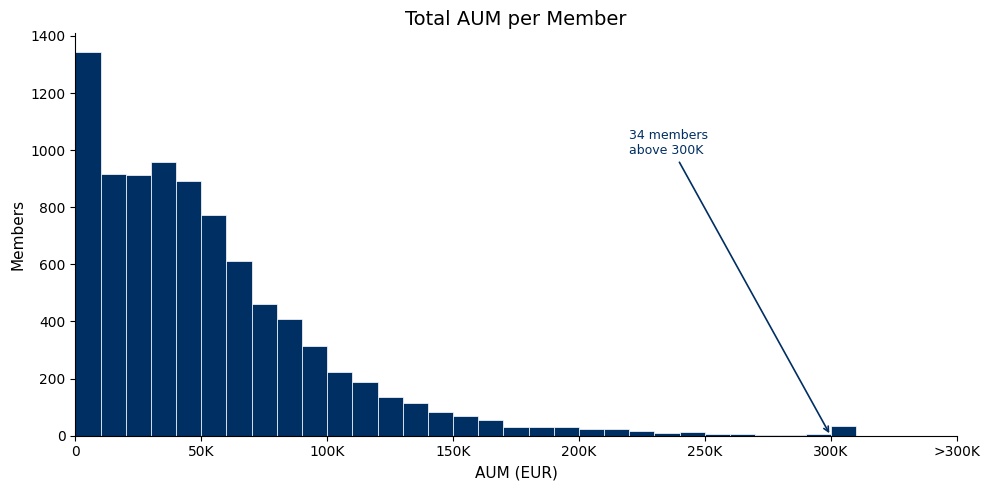

In [6]:
# Total AUM distribution (members with AUM > 0, capped at 300K)
aum_positive = df.loc[df['Total AUM'] > 0, 'Total AUM']
aum_capped = aum_positive.clip(upper=300000)
n_above = (aum_positive > 300000).sum()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(aum_capped, bins=range(0, 310001, 10000), color=TULEVA_NAVY, edgecolor='white', linewidth=0.5)
ax.set_title('Total AUM per Member')
ax.set_xlabel('AUM (EUR)')
ax.set_ylabel('Members')
ax.set_xlim(0, 310000)
ax.set_xticks(range(0, 350001, 50000))
ax.set_xticklabels(['0', '50K', '100K', '150K', '200K', '250K', '300K', '>300K'])

ax.annotate(f'{n_above:,} members\nabove 300K',
            xy=(300000, 0), xytext=(220000, ax.get_ylim()[1] * 0.7),
            fontsize=9, color=TULEVA_NAVY,
            arrowprops=dict(arrowstyle='->', color=TULEVA_NAVY, lw=1.2))

plt.tight_layout()
plt.show()

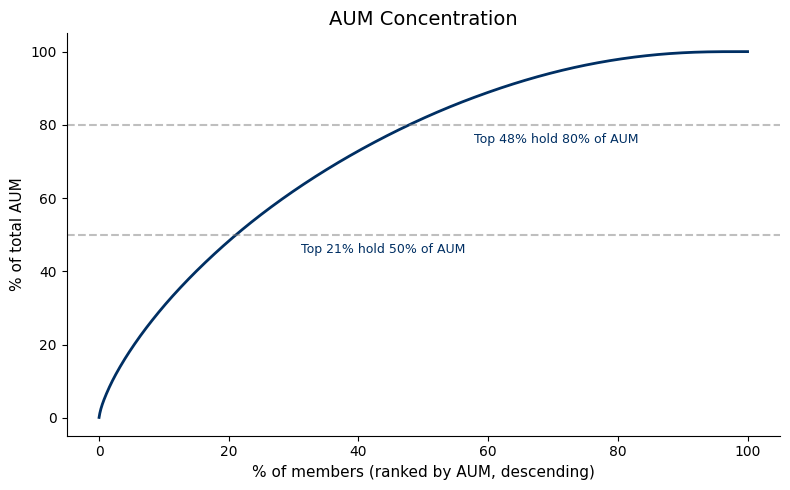

In [7]:
# AUM concentration — what share of total AUM do top N% of members hold?
aum_sorted = df.loc[df['Total AUM'] > 0, 'Total AUM'].sort_values(ascending=False)
cumulative_share = aum_sorted.cumsum() / aum_sorted.sum()
member_pct = np.arange(1, len(aum_sorted) + 1) / len(aum_sorted) * 100

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(member_pct, cumulative_share * 100, color=TULEVA_NAVY, linewidth=2)
ax.set_xlabel('% of members (ranked by AUM, descending)')
ax.set_ylabel('% of total AUM')
ax.set_title('AUM Concentration')
ax.axhline(y=50, color='grey', linestyle='--', alpha=0.5)
ax.axhline(y=80, color='grey', linestyle='--', alpha=0.5)

# Annotate key thresholds
for threshold in [50, 80]:
    idx = np.searchsorted(cumulative_share.values * 100, threshold)
    if idx < len(member_pct):
        pct = member_pct[idx]
        ax.annotate(f'Top {pct:.0f}% hold {threshold}% of AUM',
                    xy=(pct, threshold), fontsize=9, color=TULEVA_NAVY,
                    xytext=(pct + 10, threshold - 5))

plt.tight_layout()
plt.show()

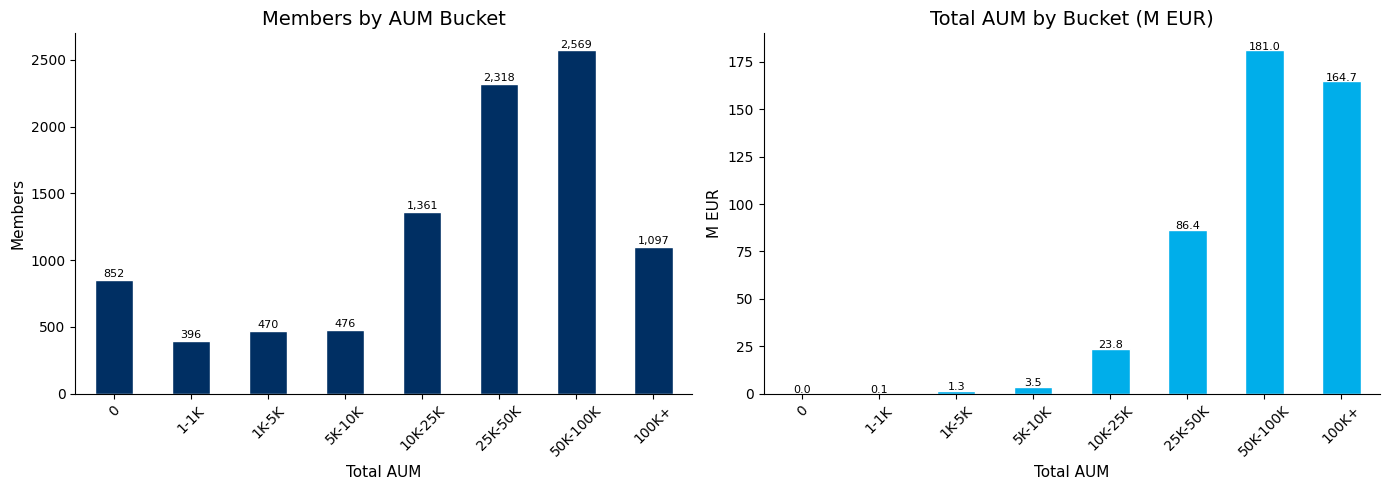

In [8]:
# AUM buckets
aum_eur = df['Total AUM']
buckets = pd.cut(aum_eur, bins=[-1, 0, 1000, 5000, 10000, 25000, 50000, 100000, float('inf')],
                 labels=['0', '1-1K', '1K-5K', '5K-10K', '10K-25K', '25K-50K', '50K-100K', '100K+'])
bucket_counts = buckets.value_counts().sort_index()
bucket_aum = aum_eur.groupby(buckets).sum().sort_index() / 1e6

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bucket_counts.plot(kind='bar', ax=axes[0], color=TULEVA_NAVY, edgecolor='white')
axes[0].set_title('Members by AUM Bucket')
axes[0].set_ylabel('Members')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(bucket_counts):
    axes[0].text(i, v + 20, f'{v:,}', ha='center', fontsize=8)

bucket_aum.plot(kind='bar', ax=axes[1], color=TULEVA_BLUE, edgecolor='white')
axes[1].set_title('Total AUM by Bucket (M EUR)')
axes[1].set_ylabel('M EUR')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(bucket_aum):
    axes[1].text(i, v + 0.5, f'{v:.1f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## 3. Withdrawal Analysis

In [9]:
# Withdrawal flags (mutually exclusive groups)
has_early_wd = df['Early Withdrawal Date'].notna()
has_transfer = df['Last Transfer Out Date'].notna()
has_iii_redeemed = df['Third Pillar All Shares Redeemed Date'].notna()
has_ii_ended = df['Second Pillar End Date'].notna()
has_ii_pension_age = has_ii_ended & ~has_early_wd

# II pillar withdrawal type (priority: early > transfer > pension age)
ii_type = pd.Series('No II withdrawal', index=df.index)
ii_type[has_ii_pension_age] = 'II after pension age'
ii_type[has_transfer] = 'Transfer out'
ii_type[has_early_wd] = 'Early withdrawal'

# Combined mutually exclusive group
iii_suffix = np.where(has_iii_redeemed, ' + III redeemed', '')
df['Withdrawal Group'] = ii_type + iii_suffix
df['Withdrawal Group'] = df['Withdrawal Group'].replace({
    'No II withdrawal': 'No withdrawals',
    'No II withdrawal + III redeemed': 'III redeemed only',
})

# Summary table
wd_order = [
    'Early withdrawal + III redeemed',
    'Early withdrawal',
    'Transfer out + III redeemed',
    'Transfer out',
    'II after pension age',
    'III redeemed only',
    'No withdrawals',
]
wd_counts = df['Withdrawal Group'].value_counts().reindex(wd_order, fill_value=0)

wd_summary = pd.DataFrame({
    'Group': wd_order,
    'Count': wd_counts.values,
    '% of Total': wd_counts.values / len(df) * 100,
})
wd_summary.style.format({'Count': '{:,}', '% of Total': '{:.1f}%'}).hide(axis='index')

Group,Count,% of Total
Early withdrawal + III redeemed,122,1.3%
Early withdrawal,"1,037",10.9%
Transfer out + III redeemed,38,0.4%
Transfer out,706,7.4%
II after pension age,60,0.6%
III redeemed only,107,1.1%
No withdrawals,"7,469",78.3%


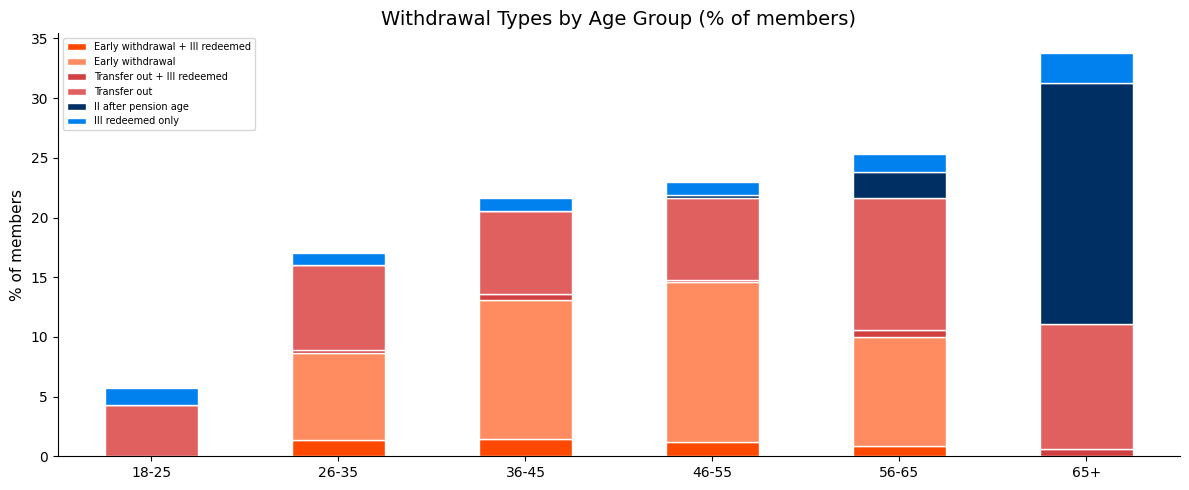

In [10]:
# Withdrawal groups by age
wd_dummies = pd.get_dummies(df['Withdrawal Group'])
wd_cols_chart = [c for c in wd_order if c != 'No withdrawals']
wd_by_age = df.join(wd_dummies).groupby('Age Group', observed=True)[wd_cols_chart].mean() * 100

fig, ax = plt.subplots(figsize=(12, 5))
colors_wd = [NEGATIVE_COLOR, '#FF8C60', '#D04040', '#E06060', TULEVA_NAVY, TULEVA_MID_BLUE]
wd_by_age.plot(kind='bar', stacked=True, ax=ax, color=colors_wd[:len(wd_cols_chart)], edgecolor='white')
ax.set_title('Withdrawal Types by Age Group (% of members)')
ax.set_ylabel('% of members')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

## 4. Savings Behavior

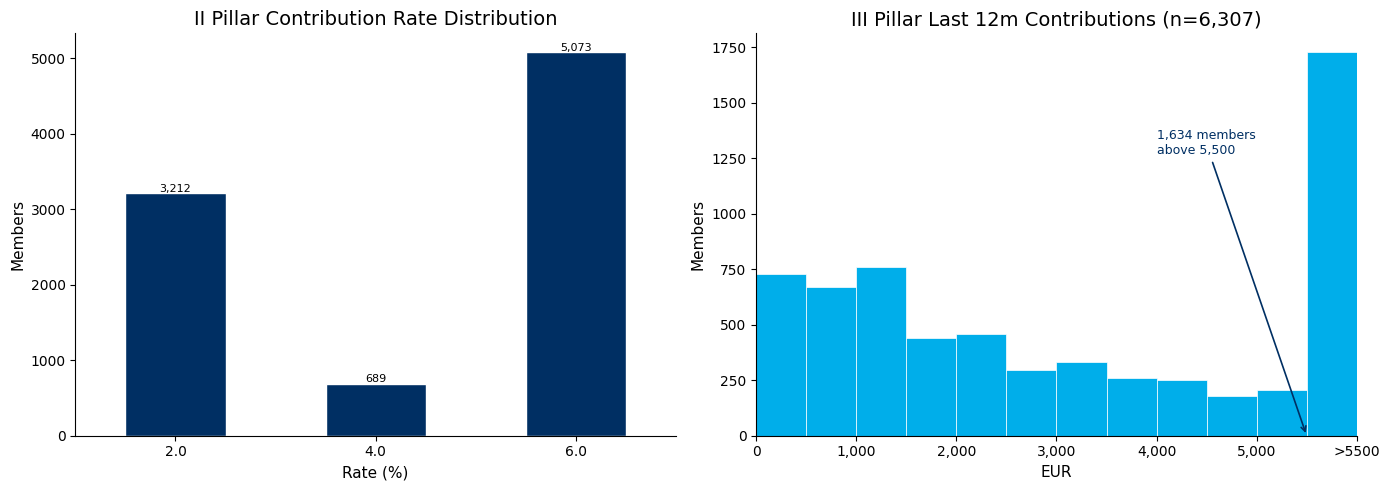

III pillar contributors (last 12m): 6,307
Mean contribution: 3,172 EUR
Median contribution: 2,600 EUR


In [11]:
# II Pillar contribution rate distribution
rates = df.loc[df['Current Rate'].notna(), 'Current Rate']
rate_counts = rates.value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rate_counts.plot(kind='bar', ax=axes[0], color=TULEVA_NAVY, edgecolor='white')
axes[0].set_title('II Pillar Contribution Rate Distribution')
axes[0].set_xlabel('Rate (%)')
axes[0].set_ylabel('Members')
axes[0].tick_params(axis='x', rotation=0)
for i, (rate, count) in enumerate(rate_counts.items()):
    axes[0].text(i, count + 20, f'{count:,}', ha='center', fontsize=8)

# III Pillar contributions (last 12 months), capped at 5500
iii_contrib = df.loc[df['Third Pillar Last 12m Contributions Sum'].notna() &
                     (df['Third Pillar Last 12m Contributions Sum'] > 0),
                     'Third Pillar Last 12m Contributions Sum']
iii_capped = iii_contrib.clip(upper=5500)

axes[1].hist(iii_capped, bins=range(0, 6001, 500), color=TULEVA_BLUE, edgecolor='white', linewidth=0.5)
axes[1].set_title(f'III Pillar Last 12m Contributions (n={len(iii_contrib):,})')
axes[1].set_xlabel('EUR')
axes[1].set_ylabel('Members')
axes[1].set_xlim(0, 6000)
ticks = list(range(0, 6001, 1000))
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([f'{t:,}' if t < 5500 else '>5500' for t in ticks])

n_above = (iii_contrib > 5500).sum()
axes[1].annotate(f'{n_above:,} members\nabove 5,500',
                 xy=(5500, 0), xytext=(4000, axes[1].get_ylim()[1] * 0.7),
                 fontsize=9, color=TULEVA_NAVY,
                 arrowprops=dict(arrowstyle='->', color=TULEVA_NAVY, lw=1.2))

plt.tight_layout()
plt.show()

print(f'III pillar contributors (last 12m): {len(iii_contrib):,}')
print(f'Mean contribution: {iii_contrib.mean():,.0f} EUR')
print(f'Median contribution: {iii_contrib.median():,.0f} EUR')

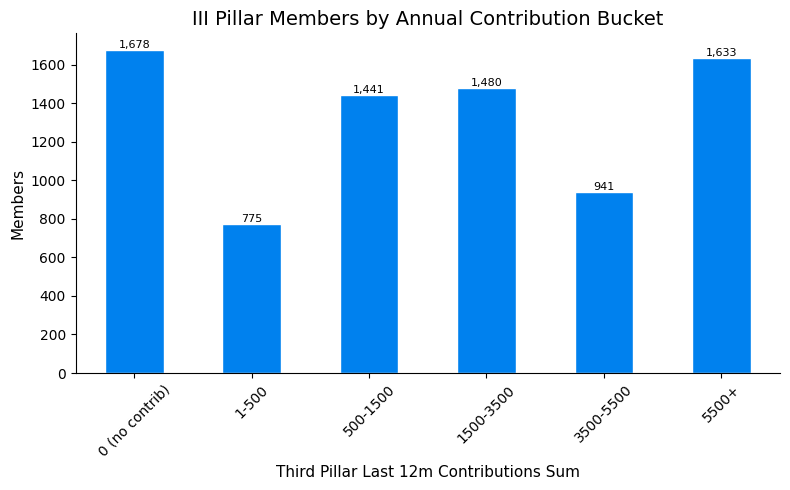

In [12]:
# III pillar contribution buckets
iii_all = df.loc[df['Has III Pillar'], 'Third Pillar Last 12m Contributions Sum'].fillna(0)
iii_buckets = pd.cut(iii_all, bins=[-1, 0, 500, 1500, 3500, 5500, float('inf')],
                     labels=['0 (no contrib)', '1-500', '500-1500', '1500-3500', '3500-5500', '5500+'])
iii_bucket_counts = iii_buckets.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
iii_bucket_counts.plot(kind='bar', ax=ax, color=TULEVA_MID_BLUE, edgecolor='white')
ax.set_title('III Pillar Members by Annual Contribution Bucket')
ax.set_ylabel('Members')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(iii_bucket_counts):
    ax.text(i, v + 10, f'{v:,}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

In [13]:
# Combined II + III pillar savings behavior
iii_c = df['Third Pillar Last 12m Contributions Sum'].fillna(0)
rate_c = df['Current Rate'].fillna(0)

def assign_savings_group(r, iii_val):
    r6 = r >= 6
    if r6 and iii_val >= 5500:
        return 'II 6% + III 5500+'
    if r6 and iii_val >= 1500:
        return 'II 6% + III 1500-5500'
    if r6:
        return 'II 6% + III <1500'
    if iii_val >= 5500:
        return 'II <6% + III 5500+'
    if iii_val >= 1500:
        return 'II <6% + III 1500-5500'
    return 'Others'

df['Savings Group'] = [assign_savings_group(r, i) for r, i in zip(rate_c, iii_c)]

savings_order = [
    'II 6% + III 5500+',
    'II 6% + III 1500-5500',
    'II 6% + III <1500',
    'II <6% + III 5500+',
    'II <6% + III 1500-5500',
    'Others',
]

rows = []
for g in savings_order:
    sub = df[df['Savings Group'] == g]
    sal = sub['Latest Salary'].dropna()
    iii_pos = sub.loc[sub['Third Pillar Last 12m Contributions Sum'] > 0, 'Third Pillar Last 12m Contributions Sum']
    rows.append({
        'Group': g,
        'Members': len(sub),
        '% of Total': len(sub) / len(df) * 100,
        'Mean AUM (EUR)': sub['Total AUM'].mean(),
        'Median Salary': sal.median() if len(sal) else 0,
        'Mean III Contrib': iii_pos.mean() if len(iii_pos) else 0,
        'Median Age': sub['Age'].median(),
    })

savings_tbl = pd.DataFrame(rows)
savings_tbl.style.format({
    'Members': '{:,}',
    '% of Total': '{:.1f}%',
    'Mean AUM (EUR)': '{:,.0f}',
    'Median Salary': '{:,.0f}',
    'Mean III Contrib': '{:,.0f}',
    'Median Age': '{:.0f}',
}).hide(axis='index')

Group,Members,% of Total,Mean AUM (EUR),Median Salary,Mean III Contrib,Median Age
II 6% + III 5500+,"1,392",14.6%,"97,897","5,000","6,316",41
II 6% + III 1500-5500,"1,611",16.9%,"59,518","2,914","3,181",43
II 6% + III <1500,"2,070",21.7%,"42,321","2,621",754,43
II <6% + III 5500+,334,3.5%,"78,157","5,131","6,391",42
II <6% + III 1500-5500,810,8.5%,"49,283","3,478","2,963",44
Others,"3,322",34.8%,"22,610","2,494",686,44


## 5. Demographics

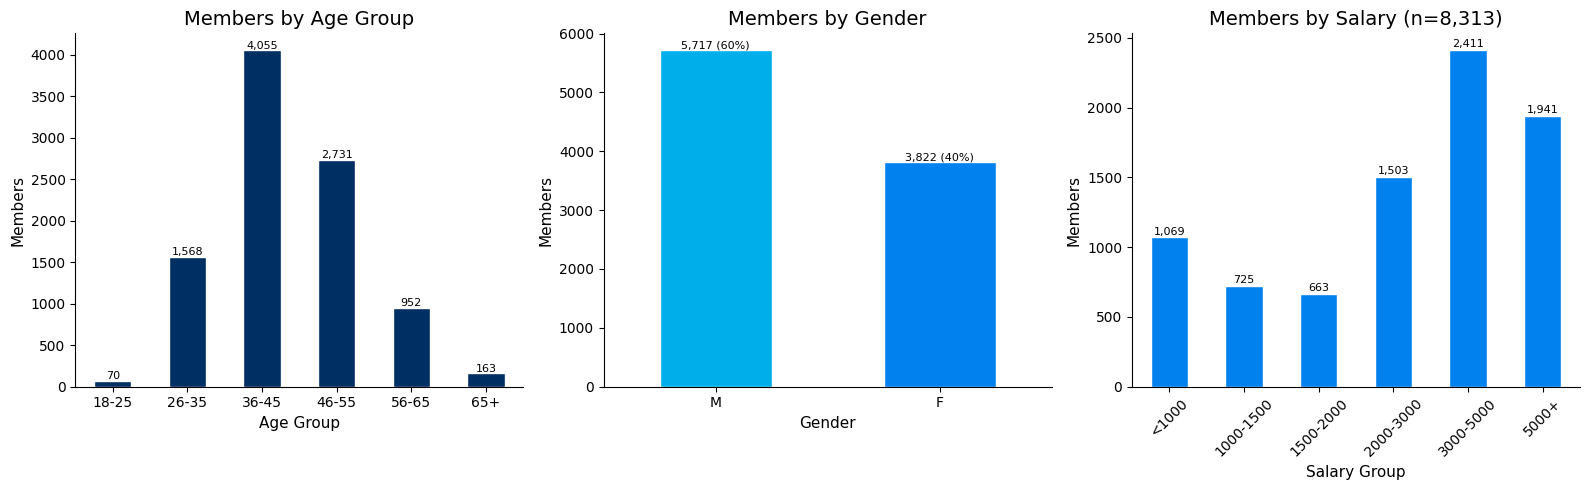

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Age distribution
age_counts = df['Age Group'].value_counts().sort_index()
age_counts.plot(kind='bar', ax=axes[0], color=TULEVA_NAVY, edgecolor='white')
axes[0].set_title('Members by Age Group')
axes[0].set_ylabel('Members')
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate(age_counts):
    axes[0].text(i, v + 20, f'{v:,}', ha='center', fontsize=8)

# Gender split
gender_counts = df['Gender'].value_counts()
gender_counts.plot(kind='bar', ax=axes[1], color=[TULEVA_BLUE, TULEVA_MID_BLUE], edgecolor='white')
axes[1].set_title('Members by Gender')
axes[1].set_ylabel('Members')
axes[1].tick_params(axis='x', rotation=0)
for i, v in enumerate(gender_counts):
    axes[1].text(i, v + 20, f'{v:,} ({v/len(df):.0%})', ha='center', fontsize=8)

# Salary distribution
salary_counts = df['Salary Group'].value_counts().sort_index()
salary_counts.plot(kind='bar', ax=axes[2], color=TULEVA_MID_BLUE, edgecolor='white')
axes[2].set_title(f'Members by Salary (n={df["Latest Salary"].notna().sum():,})')
axes[2].set_ylabel('Members')
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(salary_counts):
    axes[2].text(i, v + 20, f'{v:,}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

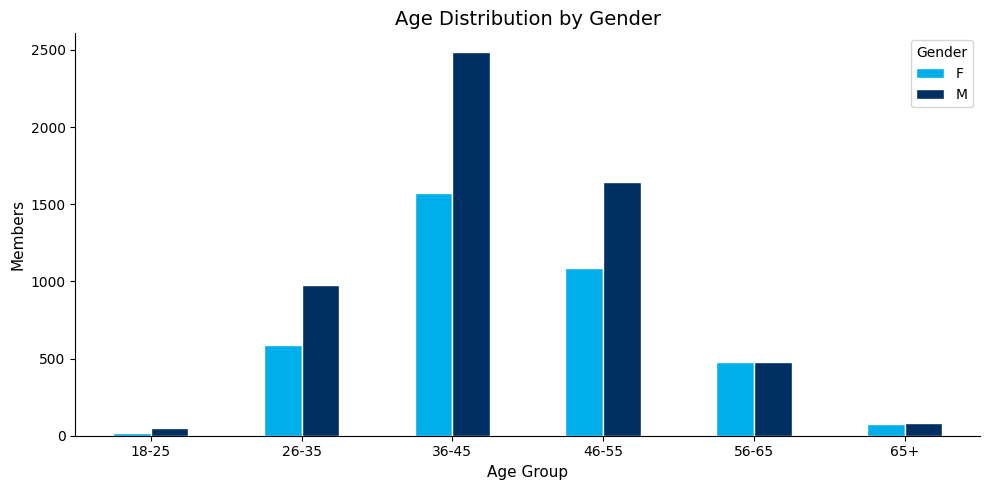

In [15]:
# Age by gender
age_gender = df.groupby(['Age Group', 'Gender'], observed=True).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
age_gender.plot(kind='bar', ax=ax, color=[TULEVA_BLUE, TULEVA_NAVY], edgecolor='white')
ax.set_title('Age Distribution by Gender')
ax.set_ylabel('Members')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Gender')
plt.tight_layout()
plt.show()

## 6. Cross-tabulations

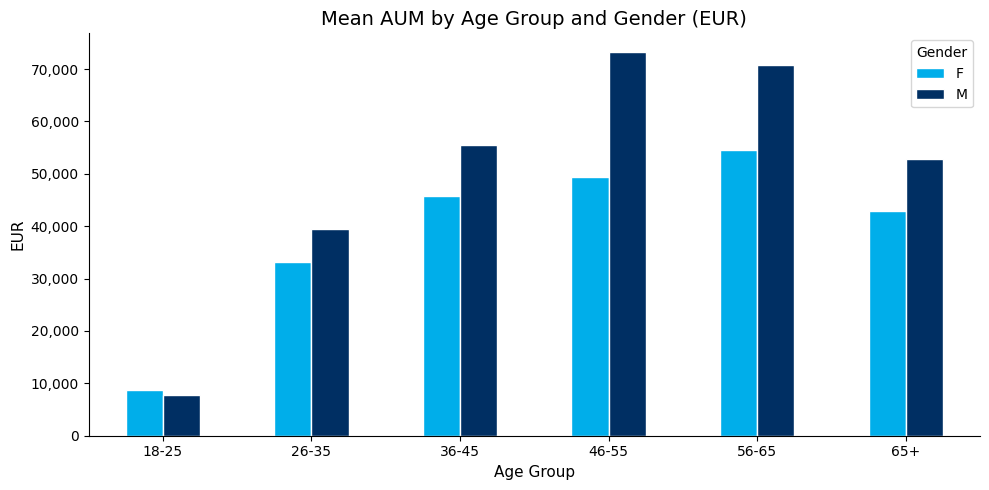

In [16]:
# Mean Total AUM by age group and gender
aum_by_age_gender = df.loc[df['Total AUM'] > 0].groupby(
    ['Age Group', 'Gender'], observed=True
)['Total AUM'].mean().unstack()

fig, ax = plt.subplots(figsize=(10, 5))
aum_by_age_gender.plot(kind='bar', ax=ax, color=[TULEVA_BLUE, TULEVA_NAVY], edgecolor='white')
ax.set_title('Mean AUM by Age Group and Gender (EUR)')
ax.set_ylabel('EUR')
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.legend(title='Gender')
plt.tight_layout()
plt.show()

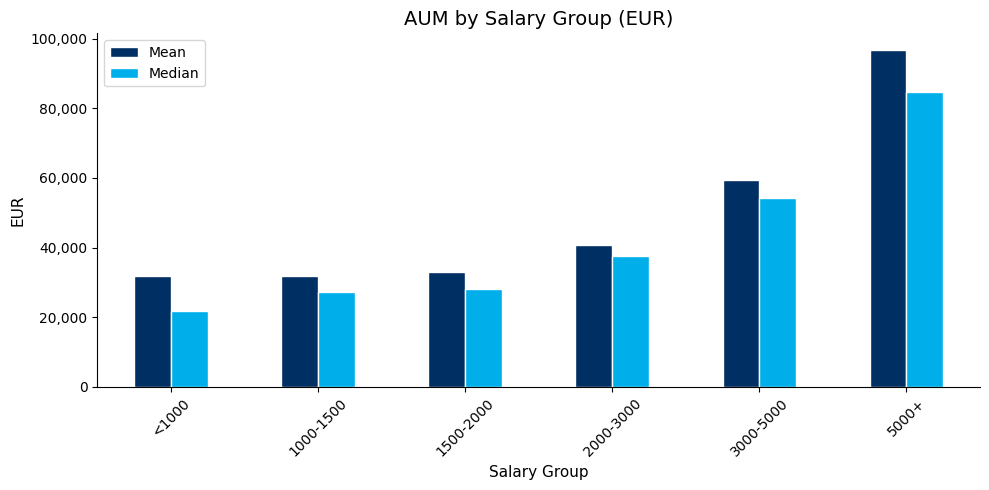

,Mean AUM (EUR),Median AUM (EUR),Members
Salary Group,,,
<1000,"31,813","21,709",947
1000-1500,"31,890","27,244",658
1500-2000,"32,833","28,040",603
2000-3000,"40,600","37,656","1,419"
3000-5000,"59,443","54,309","2,314"
5000+,"96,733","84,612","1,862"


In [17]:
# Mean AUM by salary group
aum_by_salary = df.loc[df['Total AUM'] > 0].groupby(
    'Salary Group', observed=True
)['Total AUM'].agg(['mean', 'median', 'count'])

fig, ax = plt.subplots(figsize=(10, 5))
aum_by_salary[['mean', 'median']].plot(kind='bar', ax=ax, color=[TULEVA_NAVY, TULEVA_BLUE], edgecolor='white')
ax.set_title('AUM by Salary Group (EUR)')
ax.set_ylabel('EUR')
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.legend(['Mean', 'Median'])
plt.tight_layout()
plt.show()

aum_by_salary.rename(columns={'mean': 'Mean AUM (EUR)', 'median': 'Median AUM (EUR)', 'count': 'Members'}).style.format({
    'Mean AUM (EUR)': '{:,.0f}', 'Median AUM (EUR)': '{:,.0f}', 'Members': '{:,.0f}'
})

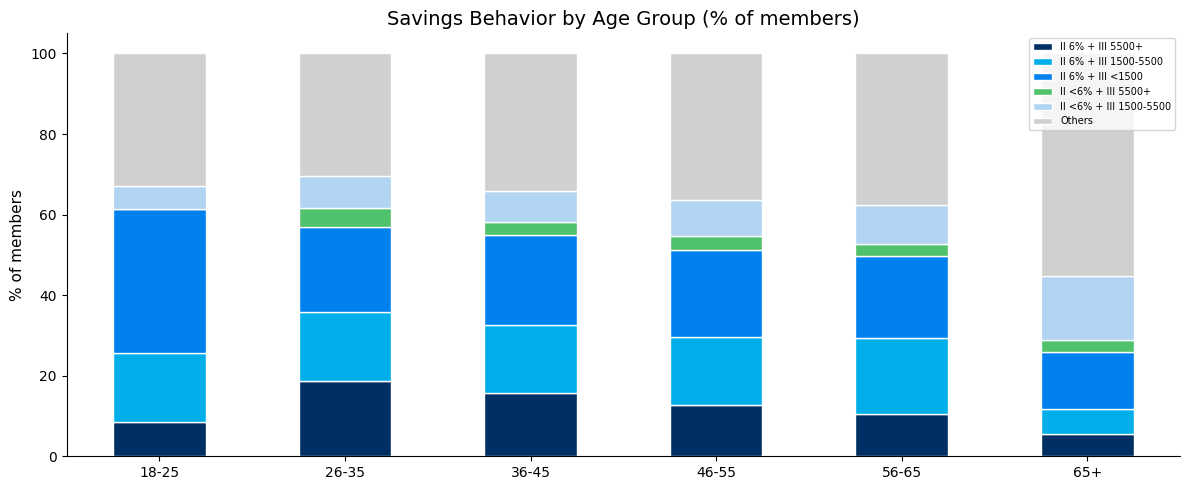

In [18]:
# Savings groups by age
sg_dummies = pd.get_dummies(df['Savings Group'])
sg_by_age = df.join(sg_dummies).groupby('Age Group', observed=True)[savings_order].mean() * 100

fig, ax = plt.subplots(figsize=(12, 5))
sg_colors = [TULEVA_NAVY, TULEVA_BLUE, TULEVA_MID_BLUE, '#51c26c', '#B0D4F1', '#D0D0D0']
sg_by_age.plot(kind='bar', stacked=True, ax=ax, color=sg_colors, edgecolor='white')
ax.set_title('Savings Behavior by Age Group (% of members)')
ax.set_ylabel('% of members')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

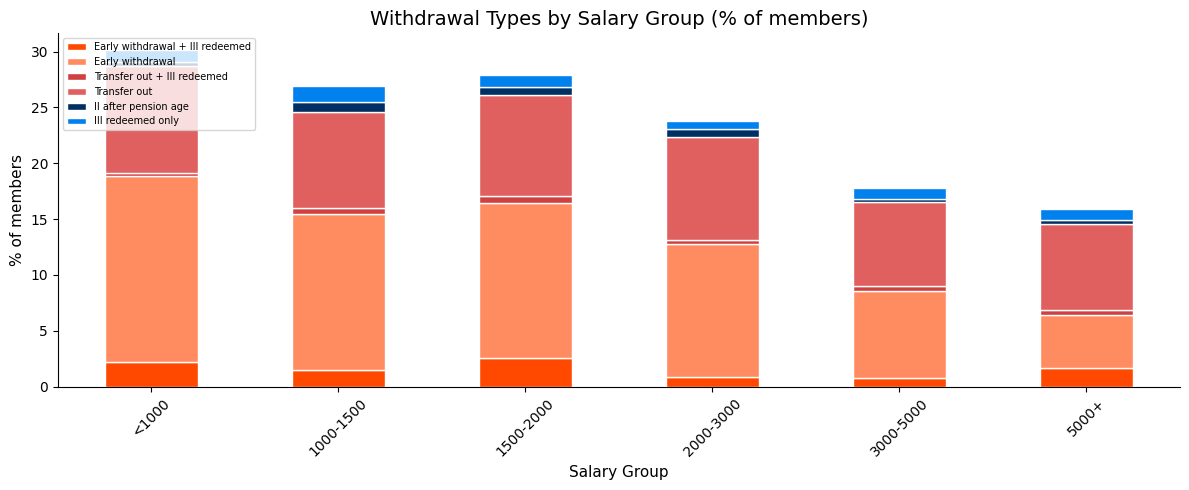

In [19]:
# Withdrawal rates by salary group (using mutually exclusive groups)
wd_by_salary = df.loc[df['Latest Salary'].notna()].join(wd_dummies).groupby(
    'Salary Group', observed=True
)[wd_cols_chart].mean() * 100

fig, ax = plt.subplots(figsize=(12, 5))
wd_by_salary.plot(kind='bar', stacked=True, ax=ax, color=colors_wd[:len(wd_cols_chart)], edgecolor='white')
ax.set_title('Withdrawal Types by Salary Group (% of members)')
ax.set_ylabel('% of members')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

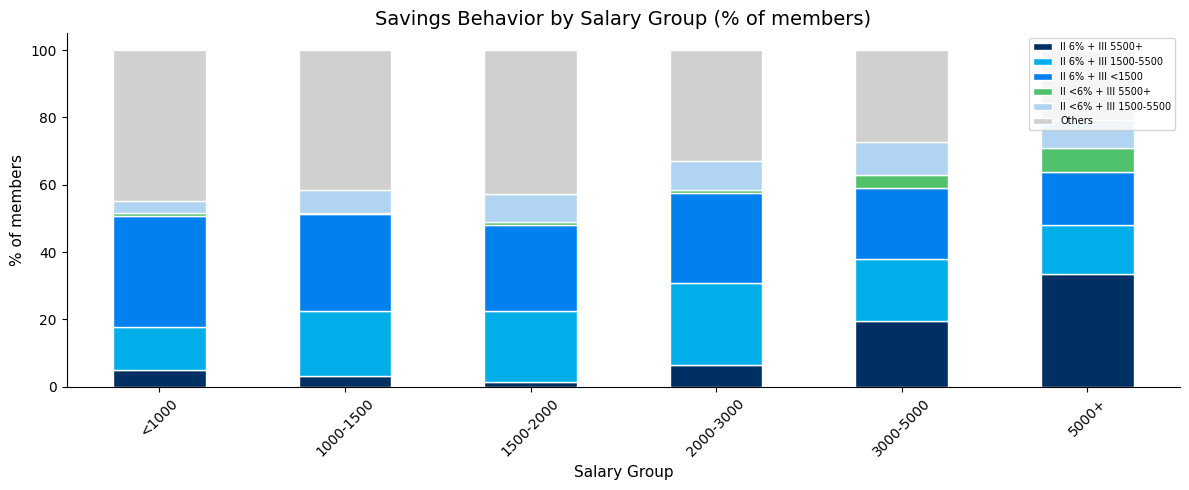

In [20]:
# Savings groups by salary
sg_by_salary = df.loc[df['Latest Salary'].notna()].join(sg_dummies).groupby(
    'Salary Group', observed=True
)[savings_order].mean() * 100

fig, ax = plt.subplots(figsize=(12, 5))
sg_by_salary.plot(kind='bar', stacked=True, ax=ax, color=sg_colors, edgecolor='white')
ax.set_title('Savings Behavior by Salary Group (% of members)')
ax.set_ylabel('% of members')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

## 7. Combined Analysis — What Drives Member Behavior?

In [21]:
# Derived columns needed for combined analysis
df['Left Tuleva'] = df['Early Withdrawal Date'].notna() | df['Last Transfer Out Date'].notna()
df['Voluntary Rate'] = df['Current Rate'] > 2
df['III Annual Contrib'] = df['Third Pillar Last 12m Contributions Sum']
df['III Savings Rate'] = np.where(
    (df['III Annual Contrib'] > 0) & (df['Latest Salary'] > 0),
    df['III Annual Contrib'] / (df['Latest Salary'] * 12) * 100,
    np.nan
)

# Finer age bins for line charts
df['Age 5y'] = pd.cut(df['Age'], bins=[0, 25, 30, 35, 40, 45, 50, 55, 60, 65, 100],
                       labels=['18-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '65+'])

# Broader salary tiers for cross-tabs
df['Salary Tier'] = pd.cut(df['Latest Salary'], bins=[0, 1500, 2500, 5000, 100000],
                           labels=['<1.5K', '1.5-2.5K', '2.5-5K', '5K+'])

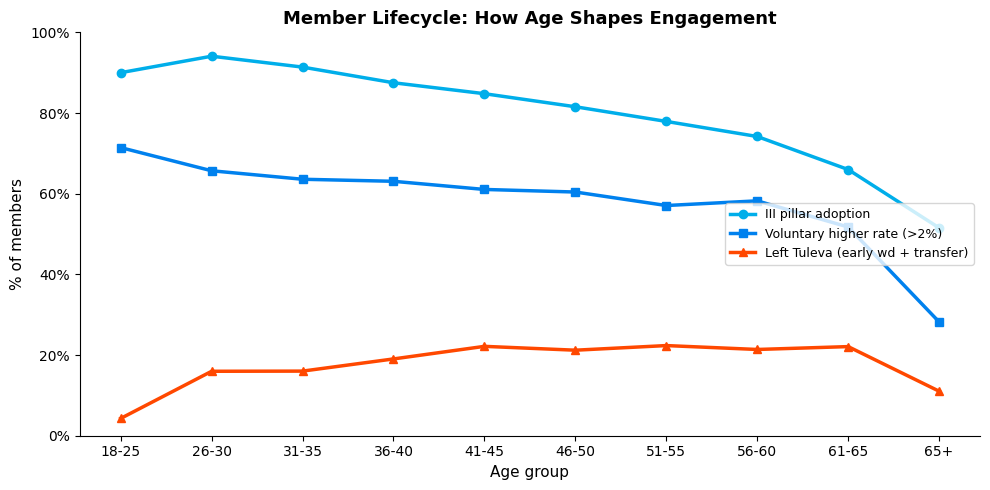

In [22]:
# CHART 1: Member Lifecycle — How age shapes engagement
age_stats = df.groupby('Age 5y', observed=True).agg(
    iii_adoption=('Has III Pillar', 'mean'),
    voluntary_rate=('Voluntary Rate', 'mean'),
    left_tuleva=('Left Tuleva', 'mean'),
).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(age_stats))

ax.plot(x, age_stats['iii_adoption'] * 100, 'o-', color=TULEVA_BLUE, linewidth=2.5, markersize=6, label='III pillar adoption')
ax.plot(x, age_stats['voluntary_rate'] * 100, 's-', color=TULEVA_MID_BLUE, linewidth=2.5, markersize=6, label='Voluntary higher rate (>2%)')
ax.plot(x, age_stats['left_tuleva'] * 100, '^-', color=NEGATIVE_COLOR, linewidth=2.5, markersize=6, label='Left Tuleva (early wd + transfer)')

ax.set_xticks(x)
ax.set_xticklabels(age_stats['Age 5y'])
ax.set_xlabel('Age group')
ax.set_ylabel('% of members')
ax.set_title('Member Lifecycle: How Age Shapes Engagement', fontsize=13, fontweight='bold')
ax.legend(loc='center right', fontsize=9)
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
plt.tight_layout()
plt.show()

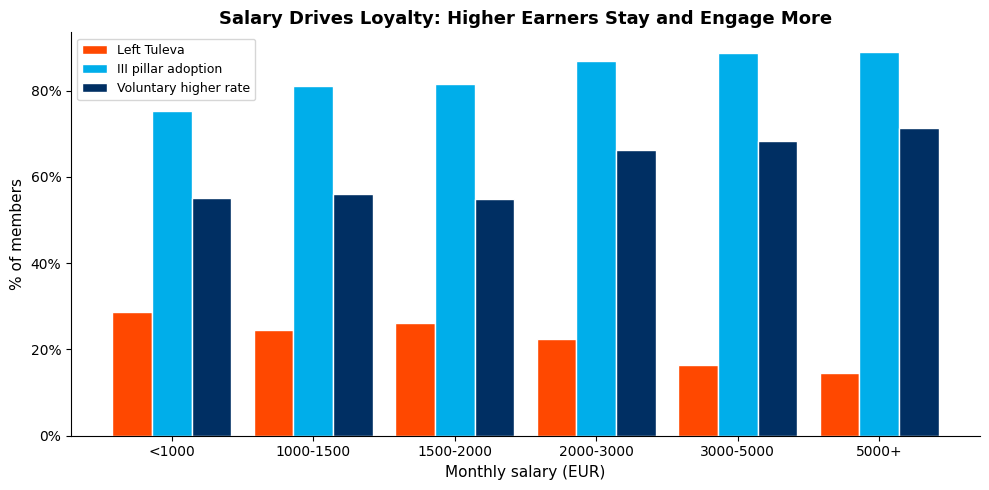

In [23]:
# CHART 2: Salary Drives Loyalty — Higher earners stay and save more
sal_stats = df[df['Latest Salary'].notna()].groupby('Salary Group', observed=True).agg(
    left_pct=('Left Tuleva', 'mean'),
    iii_adoption=('Has III Pillar', 'mean'),
    voluntary_rate=('Voluntary Rate', 'mean'),
).reset_index()

fig, ax_bar = plt.subplots(figsize=(10, 5))
x = np.arange(len(sal_stats))
w = 0.28

bars1 = ax_bar.bar(x - w, sal_stats['left_pct'] * 100, w, color=NEGATIVE_COLOR, label='Left Tuleva', edgecolor='white')
bars2 = ax_bar.bar(x, sal_stats['iii_adoption'] * 100, w, color=TULEVA_BLUE, label='III pillar adoption', edgecolor='white')
bars3 = ax_bar.bar(x + w, sal_stats['voluntary_rate'] * 100, w, color=TULEVA_NAVY, label='Voluntary higher rate', edgecolor='white')

ax_bar.set_xticks(x)
ax_bar.set_xticklabels(sal_stats['Salary Group'])
ax_bar.set_xlabel('Monthly salary (EUR)')
ax_bar.set_ylabel('% of members')
ax_bar.set_title('Salary Drives Loyalty: Higher Earners Stay and Engage More', fontsize=13, fontweight='bold')
ax_bar.legend(fontsize=9)
ax_bar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))

plt.tight_layout()
plt.show()

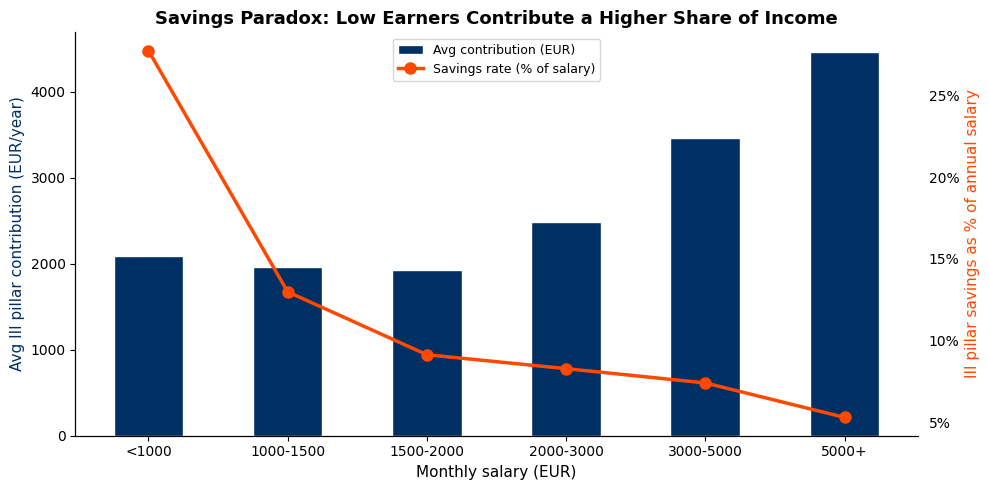

In [24]:
# CHART 3: Savings Paradox — Low earners save a higher % of income
sal_savings = df[df['Latest Salary'].notna()].groupby('Salary Group', observed=True).agg(
    mean_contrib=('III Annual Contrib', lambda s: s[s > 0].mean() if (s > 0).any() else 0),
    mean_rate=('III Savings Rate', 'mean'),
).reset_index()

fig, ax_left = plt.subplots(figsize=(10, 5))
ax_right = ax_left.twinx()

x = np.arange(len(sal_savings))
bars = ax_left.bar(x, sal_savings['mean_contrib'], 0.5, color=TULEVA_NAVY, edgecolor='white', label='Avg contribution (EUR)', zorder=2)
line = ax_right.plot(x, sal_savings['mean_rate'], 'o-', color=NEGATIVE_COLOR, linewidth=2.5, markersize=8, label='Savings rate (% of salary)', zorder=3)

ax_left.set_xticks(x)
ax_left.set_xticklabels(sal_savings['Salary Group'])
ax_left.set_xlabel('Monthly salary (EUR)')
ax_left.set_ylabel('Avg III pillar contribution (EUR/year)', color=TULEVA_NAVY)
ax_right.set_ylabel('III pillar savings as % of annual salary', color=NEGATIVE_COLOR)
ax_right.tick_params(axis='y', length=0, pad=8)
ax_right.spines['right'].set_visible(False)
ax_right.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))

# Combined legend
lines1, labels1 = ax_left.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax_left.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=9)

ax_left.set_title('Savings Paradox: Low Earners Contribute a Higher Share of Income', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

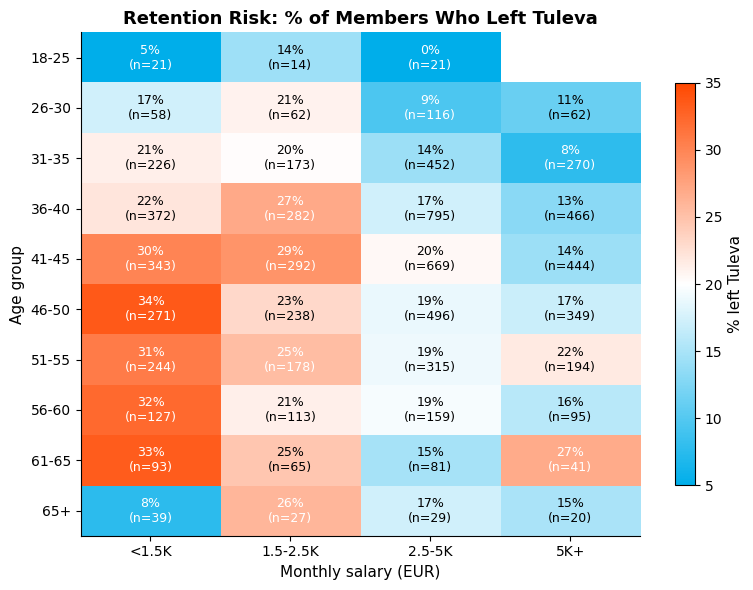

In [25]:
# CHART 4: Retention Heatmap — Age x Salary -> % left Tuleva
import matplotlib.colors as mcolors

cross = df[df['Latest Salary'].notna()].groupby(
    ['Age 5y', 'Salary Tier'], observed=True
).agg(
    left_pct=('Left Tuleva', 'mean'),
    n=('Age', 'size'),
)

# Pivot for heatmap
heatmap_data = cross['left_pct'].unstack() * 100
heatmap_n = cross['n'].unstack()

fig, ax = plt.subplots(figsize=(8, 6))
cmap = mcolors.LinearSegmentedColormap.from_list('tuleva', [TULEVA_BLUE, '#FFFFFF', NEGATIVE_COLOR])
im = ax.imshow(heatmap_data.values, cmap=cmap, aspect='auto', vmin=5, vmax=35)

# Labels
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns)
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)
ax.set_xlabel('Monthly salary (EUR)')
ax.set_ylabel('Age group')
ax.set_title('Retention Risk: % of Members Who Left Tuleva', fontsize=13, fontweight='bold')

# Annotate each cell
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        val = heatmap_data.values[i, j]
        n = heatmap_n.values[i, j]
        if not np.isnan(val):
            color = 'white' if val > 25 or val < 10 else 'black'
            ax.text(j, i, f'{val:.0f}%\n(n={n:,.0f})', ha='center', va='center', fontsize=9, color=color)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('% left Tuleva')
plt.tight_layout()
plt.show()

## 8. Member Personas

Five mutually exclusive segments based on pillar adoption, savings behavior, and engagement.

In [26]:
# Assign personas (mutually exclusive, priority order)
def assign_persona(row):
    if row['Total AUM'] == 0:
        return 'Gone'
    if row['Has Both Pillars'] and row['Voluntary Rate'] and row['III Annual Contrib'] >= 2400:
        return 'Power Saver'
    if row['Has Both Pillars'] and (row['Voluntary Rate'] or row['III Annual Contrib'] > 0):
        return 'Steady Saver'
    if row['Has Both Pillars']:
        return 'Coaster'
    return 'Single Pillar'

df['Persona'] = df.apply(assign_persona, axis=1)

PERSONA_ORDER = ['Power Saver', 'Steady Saver', 'Coaster', 'Single Pillar', 'Gone']
PERSONA_COLORS = [TULEVA_NAVY, TULEVA_BLUE, TULEVA_MID_BLUE, '#B0D4F1', '#D0D0D0']

# Summary table
rows = []
for p in PERSONA_ORDER:
    sub = df[df['Persona'] == p]
    sal = sub['Latest Salary'].dropna()
    iii = sub.loc[sub['III Annual Contrib'] > 0, 'III Annual Contrib']
    rows.append({
        'Persona': p,
        'Members': len(sub),
        '% of Total': len(sub) / len(df) * 100,
        'AUM (M EUR)': sub['Total AUM'].sum() / 1e6,
        '% of AUM': sub['Total AUM'].sum() / df['Total AUM'].sum() * 100,
        'Median Age': sub['Age'].median(),
        'Median Salary': sal.median() if len(sal) else 0,
        'Mean AUM': sub['Total AUM'].mean(),
        '% Left': sub['Left Tuleva'].mean() * 100,
    })

summary = pd.DataFrame(rows)
summary.style.format({
    'Members': '{:,}',
    '% of Total': '{:.1f}%',
    'AUM (M EUR)': '{:.1f}',
    '% of AUM': '{:.1f}%',
    'Median Age': '{:.0f}',
    'Median Salary': '{:,.0f}',
    'Mean AUM': '{:,.0f}',
    '% Left': '{:.0f}%',
}).hide(axis='index')

Persona,Members,% of Total,AUM (M EUR),% of AUM,Median Age,Median Salary,Mean AUM,% Left
Power Saver,"2,512",26.3%,216.8,47.0%,42,"4,164","86,288",6%
Steady Saver,"3,648",38.2%,169.2,36.7%,42,"2,827","46,369",16%
Coaster,751,7.9%,23.3,5.1%,41,"2,340","31,044",33%
Single Pillar,"1,776",18.6%,51.7,11.2%,46,"2,824","29,094",25%
Gone,852,8.9%,0.0,0.0%,47,"2,063",0,56%


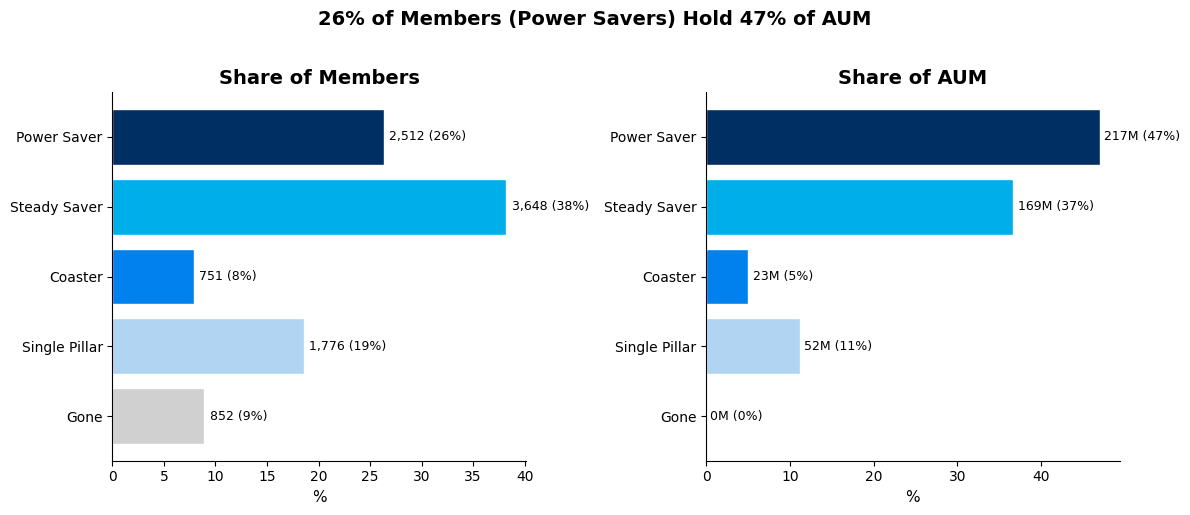

In [27]:
# Members vs AUM share — who matters most?
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

member_shares = [len(df[df['Persona'] == p]) for p in PERSONA_ORDER]
aum_shares = [df[df['Persona'] == p]['Total AUM'].sum() for p in PERSONA_ORDER]

axes[0].barh(PERSONA_ORDER[::-1], [s / len(df) * 100 for s in member_shares[::-1]],
             color=PERSONA_COLORS[::-1], edgecolor='white')
axes[0].set_title('Share of Members', fontweight='bold')
axes[0].set_xlabel('%')
for i, v in enumerate(member_shares[::-1]):
    axes[0].text(v / len(df) * 100 + 0.5, i, f'{v:,} ({v/len(df):.0%})', va='center', fontsize=9)

total_aum = sum(aum_shares)
axes[1].barh(PERSONA_ORDER[::-1], [s / total_aum * 100 for s in aum_shares[::-1]],
             color=PERSONA_COLORS[::-1], edgecolor='white')
axes[1].set_title('Share of AUM', fontweight='bold')
axes[1].set_xlabel('%')
for i, v in enumerate(aum_shares[::-1]):
    axes[1].text(v / total_aum * 100 + 0.5, i, f'{v/1e6:.0f}M ({v/total_aum:.0%})', va='center', fontsize=9)

fig.suptitle('26% of Members (Power Savers) Hold 47% of AUM', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

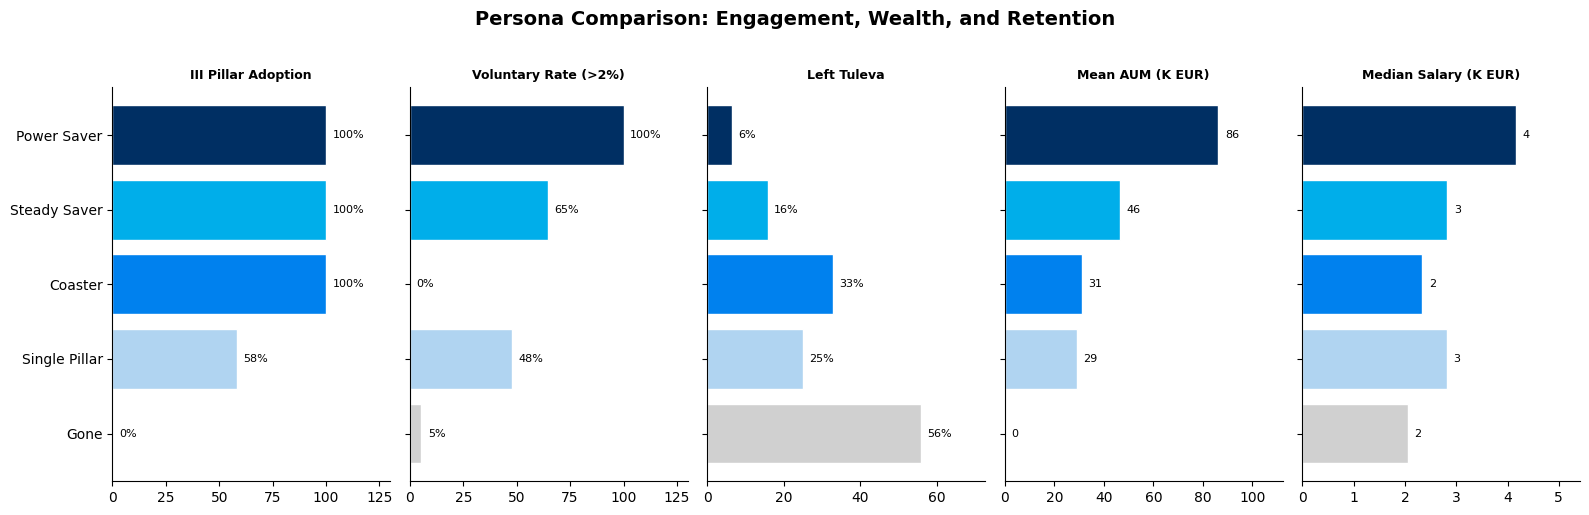

In [28]:
# Persona comparison — key behavioral metrics
metrics = []
for p in PERSONA_ORDER:
    sub = df[df['Persona'] == p]
    sal = sub['Latest Salary'].dropna()
    metrics.append({
        'Persona': p,
        'III Pillar Adoption': sub['Has III Pillar'].mean() * 100,
        'Voluntary Rate (>2%)': sub['Voluntary Rate'].mean() * 100,
        'Left Tuleva': sub['Left Tuleva'].mean() * 100,
        'Mean AUM (K EUR)': sub['Total AUM'].mean() / 1000,
        'Median Salary (K EUR)': sal.median() / 1000 if len(sal) else 0,
    })
mdf = pd.DataFrame(metrics).set_index('Persona')

fig, axes = plt.subplots(1, 5, figsize=(16, 5), sharey=True)

for i, col in enumerate(mdf.columns):
    bars = axes[i].barh(PERSONA_ORDER[::-1], mdf[col].loc[PERSONA_ORDER[::-1]],
                        color=PERSONA_COLORS[::-1], edgecolor='white')
    axes[i].set_title(col, fontsize=9, fontweight='bold')
    max_val = mdf[col].max()
    for j, v in enumerate(mdf[col].loc[PERSONA_ORDER[::-1]]):
        fmt = f'{v:.0f}%' if '%' in col or col in ['III Pillar Adoption', 'Left Tuleva'] else f'{v:.0f}'
        axes[i].text(v + max_val * 0.03, j, fmt, va='center', fontsize=8)
    axes[i].set_xlim(0, max_val * 1.3)

fig.suptitle('Persona Comparison: Engagement, Wealth, and Retention', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [29]:
# Persona descriptions
descriptions = {
    'Power Saver': {
        'emoji': '',
        'tagline': 'The backbone of Tuleva',
        'profile': '42-year-old, earns 4,200 EUR/month, 75K in AUM across both pillars',
        'behavior': 'Maximizes everything: 6% II pillar rate, 5,000+ EUR/year into III pillar. '
                    'Only 6% have ever left. These are Tuleva\'s true believers.',
        'risk': 'Low. Concentrate retention efforts elsewhere.',
    },
    'Steady Saver': {
        'emoji': '',
        'tagline': 'The reliable middle',
        'profile': '42-year-old, earns 2,800 EUR/month, 39K in AUM, both pillars',
        'behavior': 'Active in both pillars but saves less intensely. 65% chose voluntary higher rate, '
                    '81% contribute to III pillar (~1,600 EUR/year). 16% have left.',
        'risk': 'Medium. Biggest segment (38%) — nudging them toward Power Saver behavior has the highest leverage.',
    },
    'Coaster': {
        'emoji': '',
        'tagline': 'Signed up but checked out',
        'profile': '41-year-old, earns 2,300 EUR/month, 21K in AUM, both pillars',
        'behavior': 'Has both pillars but does the minimum: mandatory 2% rate, zero III pillar contributions. '
                    'One in three has already left Tuleva.',
        'risk': 'High. 33% churn and zero voluntary engagement. Re-engage or lose them.',
    },
    'Single Pillar': {
        'emoji': '',
        'tagline': 'Half in, half out',
        'profile': '46-year-old, earns 2,800 EUR/month, 18K in AUM, only one pillar',
        'behavior': 'Either II-only (39%) or III-only (58%). Older, more male. '
                    'Those with III pillar are often active savers (3,000 EUR/yr) — they just exited II pillar.',
        'risk': 'High. 25% have left. Cross-sell the missing pillar where possible.',
    },
    'Gone': {
        'emoji': '',
        'tagline': 'Left but still on the books',
        'profile': '47-year-old, earns 2,100 EUR/month, zero AUM',
        'behavior': 'Withdrew or transferred all assets. 56% formally left via early withdrawal or transfer. '
                    'Oldest and lowest-salary segment.',
        'risk': 'Write-off for retention. Study what drove them away.',
    },
}

for persona in PERSONA_ORDER:
    d = descriptions[persona]
    n = len(df[df['Persona'] == persona])
    print(f'--- {persona.upper()} ({n:,} members, {n/len(df):.0%}) — "{d["tagline"]}" ---')
    print(f'  Typical: {d["profile"]}')
    print(f'  Behavior: {d["behavior"]}')
    print(f'  Risk: {d["risk"]}')
    print()

--- POWER SAVER (2,512 members, 26%) — "The backbone of Tuleva" ---
  Typical: 42-year-old, earns 4,200 EUR/month, 75K in AUM across both pillars
  Behavior: Maximizes everything: 6% II pillar rate, 5,000+ EUR/year into III pillar. Only 6% have ever left. These are Tuleva's true believers.
  Risk: Low. Concentrate retention efforts elsewhere.

--- STEADY SAVER (3,648 members, 38%) — "The reliable middle" ---
  Typical: 42-year-old, earns 2,800 EUR/month, 39K in AUM, both pillars
  Behavior: Active in both pillars but saves less intensely. 65% chose voluntary higher rate, 81% contribute to III pillar (~1,600 EUR/year). 16% have left.
  Risk: Medium. Biggest segment (38%) — nudging them toward Power Saver behavior has the highest leverage.

--- COASTER (751 members, 8%) — "Signed up but checked out" ---
  Typical: 41-year-old, earns 2,300 EUR/month, 21K in AUM, both pillars
  Behavior: Has both pillars but does the minimum: mandatory 2% rate, zero III pillar contributions. One in three h